In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### MHD Shell model equations without the ionic term and without forcing

In [2]:
def f(Y, t, y_n, n):
    '''
    This function returns the time derivative of y_n according to the shell model system of eqn
    
    Y: complex vector representing u_n and b_n at a given time t
    y_n: element of Y vector - could be u_n or b_n
    n: shell number
    '''
    
    X = Y[:]
    X[n] = y_n
    
    if n in range(N):
        #taking care of the boundary terms
        if n==0:
            phi_u = k[0]*(X[1]*X[2]-X[N+1]*X[N+2])     
        elif n==1:
            phi_u = k[1]*(X[2]*X[3]-X[N+2]*X[N+3])-0.5*k[0]*(X[0]*X[2]-X[N]*X[N+2])
        elif n==N-2:
            phi_u = -0.5*k[n-1]*(X[n-1]*X[n+1]-X[N+n-1]*X[N+n+1])-0.5*k[n-2]*(X[n-2]*X[n-1]-X[N+n-2]*X[N+n-1])
        elif n==N-1:
            phi_u = -0.5*k[n-2]*(X[n-2]*X[n-1]-X[N+n-2]*X[N+n-1]) 
        else:
            phi_u = k[n]*(X[n+1]*X[n+2]-X[N+n+1]*X[N+n+2])-0.5*k[n-1]*(X[n-1]*X[n+1]-X[N+n-1]*X[N+n+1])-0.5*k[n-2]*(X[n-2]*X[n-1]-X[N+n-2]*X[N+n-1])
        
        yn_dot = -nu*k[n]*k[n]*X[n] - nu2*(k[n]**4)*X[n] + 1j*phi_u.conjugate()
        
    if n in range(N,2*N):
        #taking care of the boundary terms
        if n==N:
            phi_b = (1./6.)*k[0]*(X[1]*X[N+2]-X[N+1]*X[2])   
        elif n==N+1:
            phi_b = (1./6.)*k[1]*(X[2]*X[N+3]-X[N+2]*X[3])+(1./3.)*k[0]*(X[0]*X[N+2]-X[N]*X[2])
        elif n==2*N-2:
            phi_b = (1./3.)*k[n-1-N]*(X[n-1-N]*X[n+1]-X[n-1]*X[n+1-N])-(2./3.)*k[n-2-N]*(X[n-2-N]*X[n-1]-X[n-2]*X[n-1-N])
        elif n==2*N-1:
            phi_b = -(2./3.)*k[n-2-N]*(X[n-2-N]*X[n-1]-X[n-2]*X[n-1-N])    
        else:
            phi_b = (1./6.)*k[n-N]*(X[n+1-N]*X[n+2]-X[n+1]*X[n+2-N])+(1./3.)*k[n-1-N]*(X[n-1-N]*X[n+1]-X[n-1]*X[n+1-N])-(2./3.)*k[n-2-N]*(X[n-2-N]*X[n-1]-X[n-2]*X[n-1-N])
       
        yn_dot = -eta*k[n-N]*k[n-N]*X[n] - eta2*(k[n-N]**4)*X[n] + 1j*phi_b.conjugate()

    return yn_dot


### Runge-Kutta-4 method

In [3]:
def RK4(t0,tn,n,y0):
    '''
    This function returns the configuration at each time slice according to RK4
    
    t0: initial time
    tn: final time
    n : number of time slices
    y0: initial configuration vector
    '''
    h = abs(tn-t0)/n
    t = np.linspace(t0,tn,n+1)
    
    y = np.zeros([n+1,len(y0)],dtype=complex) #y[i][j] gives config at time slice i and shell j
    y[0] = y0
    
    for i in range(0,n): #i denotes the time slice  
        for j in range(len(y0)):   #j denotes the shell
            K1 = f(y[i],t[i],y[i][j],j)
            K2 = f(y[i],t[i]+h/2,y[i][j]+K1*h/2,j)
            K3 = f(y[i],t[i]+h/2,y[i][j]+K2*h/2,j)
            K4 = f(y[i],t[i]+h,y[i][j]+K3*h,j)
            y[i+1][j] = y[i][j] + h*(K1 + 2*K2 + 2*K3 + K4)/6.
    return y

### Adams-Bashforth 3/Moulton 4 Step Predictor/Corrector

In [4]:
def AdBash3_PreCorr(t0,tn,n,y0):
    '''
    This function returns the configuration at each time slice according to AB3/corrector
    
    t0: initial time
    tn: final time
    n : number of time slices
    y0: initial configuration vector
    '''
    h = abs(tn-t0)/n
    t = np.linspace(t0,tn,n+1)
    y = np.zeros([n+1,len(y0)],dtype=complex)
    #Calculate initial steps with RK4
    y[0:3] = RK4(t0,t0+2*h,2,y0)
    K0,K1,K2,K3 = (np.zeros(len(y0)) for i in range(4))
    for j in range(len(y0)):
        K1[j] = f(y[1],t[1],y[1][j],j)
        K2[j] = f(y[0],t[0],y[0][j],j)
    for i in range(2,n):
        for j in range(len(y0)):
            K3[j] = K2[j]
            K2[j] = K1[j]
            K1[j] = f(y[i],t[i],y[i][j],j)
            #Adams-Bashforth Predictor
            y[i+1][j] = y[i][j] + h*(23*K1[j]-16*K2[j]+5*K3[j])/12
            K0[j] = f(y[i+1],t[i+1],y[i+1][j],j)
            #Adams-Moulton Corrector
            y[i+1][j] = y[i][j] + h*(9*K0[j]+19*K1[j]-5*K2[j]+K3[j])/24
    return y

### Driver code

In [5]:
start_time = time.time()
Nr = 1 #number of realizations
N = 22 #number of shells

nu = 10**(-8) #kinematic viscosity
eta = 10**(-8) #magnetic diffusivity
nu2 = 5.*10**(-13) #hyperviscosity
eta2 = 5.*10**(-13) #magnetic hyperdiffusivity
k0 = 1./16.
u0 = 0.5
b0 = 0.05

n = 300 #number of time slices
t0 = 0 #initial time
tn = 30 #final time
t = np.linspace(t0,tn,n+1)

#initializing k vector
k=[]
for i in range(1,N+1):
    k.append(k0*(2**i))

uf,bf = [],[]
for _ in range(Nr):
    #initialization of the vectors u,b
    ui,bi = [],[]
    phi_u = np.random.uniform(-np.pi,np.pi,N)
    phi_b = np.random.uniform(-np.pi,np.pi,N)
    for i in range(N):
        kn = k[i]
        un = u0*kn**(-1./3.)*np.exp(-kn*kn+1j*phi_u[i])
        bn = b0*kn**(-1./3.)*np.exp(-kn*kn+1j*phi_b[i])
        ui.append(un)
        bi.append(bn)
    #initial configuration
    y0 = ui+bi
    #Solving the N differential equations using Adams-Bashforth
    ysol = AdBash3_PreCorr(t0,tn,n,y0)
    un, bn = [],[] #every element of un,bn stores the absolute values of a configuration at a given time
    for i in range(len(ysol)):
        un.append(np.abs(ysol[i][:N]))
        bn.append(np.abs(ysol[i][N:]))
    #every element of uf,bf is a realization
    uf.append(un)
    bf.append(bn)
end_time = time.time()
print('Time taken = ', end_time-start_time)

/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  0.5115132331848145


### Calculating the energy spectrum


In [6]:
#every element i of u and b gives the configuration at ith time averaged over all realizations
u = np.mean(uf,axis = 0)
b = np.mean(bf,axis = 0)

Enu = np.zeros([n+1,N]) #energy of each shell at given time
Enb = np.zeros([n+1,N])

Eu = np.zeros(n+1) #total energy at given time summed over all shells
Eb = np.zeros(n+1)

urms = [] #rms velocity
tm = [] #Taylor microscale

for i in range(n+1):
    ur = 0.
    tmfac = 0.

    for j in range(N):
        enu = 0.5*u[i][j]*u[i][j]/k[j]
        enb = 0.5*b[i][j]*b[i][j]/k[j]
        Enu[i][j] = enu
        Enb[i][j] = enb
        Eu[i]+=Enu[i][j]
        Eb[i]+=Enb[i][j]
        
        ur+=u[i][j]*u[i][j]
        tmfac+= enu*k[j]*k[j]
                
    urms.append(np.sqrt(ur))
    tm.append(np.sqrt(Eu[i]/tmfac))

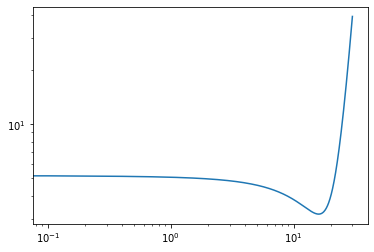

In [9]:
plt.loglog(t,Eu)

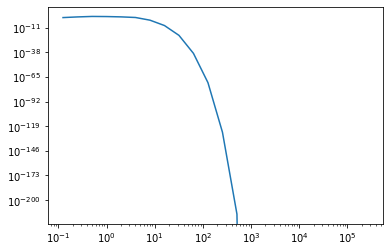

In [11]:
plt.loglog(k,Enu[-1])